# Importing required libraries 

In [ ]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use("seaborn-dark-palette")


## Reading data

In [ ]:
train = pd.read_csv("../input/nbme-score-clinical-patient-notes/train.csv")
test = pd.read_csv("../input/nbme-score-clinical-patient-notes/test.csv")
features = pd.read_csv("../input/nbme-score-clinical-patient-notes/features.csv")
ss = pd.read_csv("../input/nbme-score-clinical-patient-notes/sample_submission.csv")
patient_notes = pd.read_csv("../input/nbme-score-clinical-patient-notes/patient_notes.csv")


# Evaluation metrics 
This competition is evaluated by a `micro-averaged F1 score`.

For each instance, we predict a set of character spans. A character span is a pair of indexes representing a range of characters within a text. A span i j represents the characters with indices i through j, inclusive of i and exclusive of j. In Python notation, a span i j is equivalent to a slice i:j.

For each instance there is a collection of ground-truth spans and a collection of predicted spans. The spans we delimit with a semicolon, like: 0 3; 5 9.

We score each character index as:

TP if it is within both a ground-truth and a prediction,
FN if it is within a ground-truth but not a prediction, and,
FP if it is within a prediction but not a ground truth.
Finally, we compute an overall F1 score from the TPs, FNs, and FPs aggregated across all instances.

Example
Suppose we have an instance:

| ground-truth | prediction    |
|--------------|---------------|
| 0 3; 3 5     | 2 5; 7 9; 2 3 |
These spans give the sets of indices:

| ground-truth | prediction |
|--------------|------------|
| 0 1 2 3 4    | 2 3 4 7 8  |
We therefore compute:

TP = size of {2, 3, 4} = 3
FN = size of {0, 1} = 2
FP = size of {7, 8} = 2
Repeat for all instances, collect the TPs, FNs, and FPs, and compute the final F1 score.

## metrics function link 
>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html


In [ ]:
# importing metrics 
from sklearn.metrics import f1_score
# usage 
# f1_score(y_true, y_pred, average='macro')


# How does our data looks like?


# what are some of the important terms:
> `Clinical Case`: The scenario (e.g., symptoms, complaints, concerns) the Standardized Patient presents to the test taker (medical student, resident or physician). Ten clinical cases are represented in this dataset.

> `Patient Note`: Text detailing important information related by the patient during the encounter (physical exam and interview).

> `Feature`: A clinically relevant concept. A rubric describes the key concepts relevant to each case.


`train.csv` - Feature annotations for 1000 of the patient notes, 100 for each of ten cases.
>`id` - Unique identifier for each patient note / feature pair.

> `pn_num` - The patient note annotated in this row.

> `feature_num` - The feature annotated in this row.

> `case_num` - The case to which this patient note belongs.

> `annotation` - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.

> `location` - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;

# we have to find 100 features for test case approx

In [ ]:
#visualizing what's in the train dataset 
train.head()

# Representation of features in patient notes 

In [ ]:
def change_color(text):
     return f"\033[42;30m{text}\033[m"
def color_feature_in_text(pn_num):
    text = patient_notes.query(f"pn_num == {pn_num}")['pn_history'].values[0]
    feat_df = train.query(f"pn_num == {pn_num}").location.apply(lambda x: eval(x))
    all_feat = []
    for x in feat_df:
        samp_arr = []
        for idx,y in enumerate(x):
            if y.find(';')!=-1:
                z =  y.split(';')
                for samp in z:
                    samp_arr.append(samp)
                continue
            samp_arr.append(y)
        x = samp_arr
        for y in x:
            sp = y.split(sep = " ")
            ss = (int(sp[0]), int(sp[1]))
            all_feat.append(ss)
    all_feat= sorted(all_feat)
    text_str = ""
    for x in range(len(all_feat)):
        if x == 0 :
            if all_feat[x][0] != 0 :
                text_str+= text[0:all_feat[x][0]]
        else:
            # both color sequence check 
            if all_feat[x-1][1] != all_feat[x][0] -1 :
                text_str += str(" " + text[all_feat[x-1][1]:all_feat[x][0] -1]+ " ")
            
            text_str += change_color(text[all_feat[x][0]:all_feat[x][1]])
        if x == len(all_feat)-1 :
            if all_feat[x][1] != len(text)-1 :
                text_str += text[all_feat[x][1]:]
    

    print(text_str)

In [ ]:
import random 
r_num = random.choice(train.pn_num.unique())
color_feature_in_text(r_num)

In [ ]:
import random 
r_num = random.choice(train.pn_num.unique())
color_feature_in_text(r_num)

In [ ]:
train.describe()

In [ ]:
# how many patients data do we have 
len(train.id.unique())

In [ ]:
#test dataset visualization
test.head()

In [ ]:
test.describe()

In [ ]:
# visualizing sample submission 
ss.head()

**patient_notes.csv** - A collection of about 40,000 Patient Note history portions. Only a subset of these have features annotated. You may wish to apply unsupervised learning techniques on the notes without annotations. The patient notes in the test set are not included in the public version of this file.
> `pn_num` - A unique identifier for each patient note.

> `case_num` - A unique identifier for the clinical case a patient note represents.

> `pn_history` - The text of the encounter as recorded by the test taker.

In [ ]:
# patient notes visualization 
patient_notes.head()


In [ ]:
patient_notes.describe()

**features.csv** - The rubric of features (or key concepts) for each clinical case.
> `feature_num` - A unique identifier for each feature.

> `case_num` - A unique identifier for each case.

> `feature_text` - A description of the feature.

In [ ]:
# visualizing feature column 
features.head()

In [ ]:
features.describe()

## What do we have to calculate 

> we have to find the location with help of `features` and `patient_notes` dataframe 
# what does sample submission looks like 
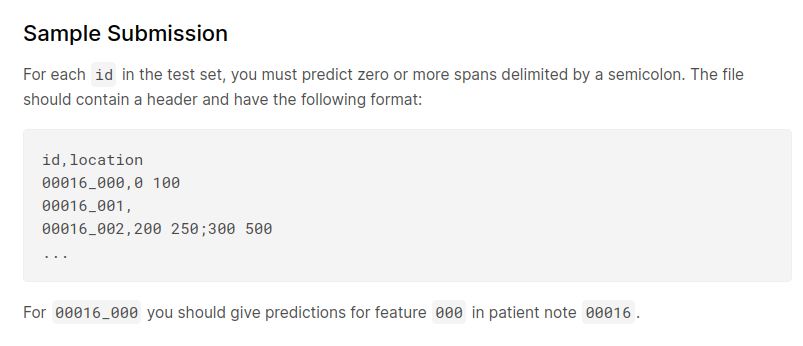

# Visualizing some of the annotations from train

In [ ]:
tot_anno = []
for x in train.annotation.apply(lambda x: eval(x)):
    for y in x:
        tot_anno.append(y)

In [ ]:
len(tot_anno), len(np.unique(tot_anno))

In [ ]:
pd.Series(tot_anno).value_counts()

## there are 5622 unique annotations from train data 

In [ ]:
plt.figure(figsize=(12,6))
train.case_num.value_counts().plot(kind='bar')
plt.xlabel("case_number")
plt.ylabel("total_numbers")
plt.title("total case numbers plot")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
test.case_num.value_counts().plot(kind='bar')
plt.xlabel("case_number")
plt.ylabel("total_numbers")
plt.title("total case numbers plot")
plt.show()

In [ ]:
train.pn_num.value_counts()


In [ ]:
train.pn_num.value_counts()

In [ ]:
test

# How I am thinking about approaching this problem 

> this competition looks similar to essay writing competition we had on kaggle previously

> using bert as feature extraction model 

> training on the transformer model ( specifically LonfFormer ) 
## The Approach 
train on features column while keeping the labels for longformer as the total locations 
> Not sure about the approach will have to look for other alternative and do some more research 


In [ ]:
train.query("id =='00016_000'")

In [ ]:
test

In [ ]:
patient_notes

In [ ]:
patient_notes.query("pn_num  == 16")